# DEEPATLAS
is a joint learning approach for weakly supervised registration and semi-supervised segmentation proposed by

[Xu, Zhenlin, and Marc Niethammer. "DeepAtlas: Joint semi-supervised learning of image registration and segmentation." International Conference on Medical Image Computing and Computer-Assisted Intervention. Cham: Springer International Publishing, 2019.](https://link.springer.com/chapter/10.1007/978-3-030-32245-8_47)

The base code used is from [DEEPATLAS.tutorial](https://github.com/Project-MONAI/tutorials/blob/main/deep_atlas/deep_atlas_tutorial.ipynb)

This code is for segmentation of MRI images for brain tissue segmentation using IBSR 18 dataset.


### ALL IMPORTS

In [1]:
import monai
import torch
import itk
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
import os.path
import tempfile
from monai.transforms import LoadImage
from monai.metrics import DiceMetric
from torch.nn.functional import one_hot

from utils import (
    preview_image,
    preview_3D_vector_field,
    preview_3D_deformation,
    jacobian_determinant,
    plot_against_epoch_numbers,
)

### CHECKING AND SPECIFYING DEVICE

In [2]:
print('Is cuda available?',torch.cuda.is_available())  # Should print True
print(torch.cuda.get_device_name(0))  # Should print your GPU name
device = torch.device("cuda:0")
print(device)

Is cuda available? True
NVIDIA GeForce RTX 3070 Laptop GPU
cuda:0


### DISABLING ALL ITK WARNING MESSAGE GLOBALLY

In [3]:
itk.ProcessObject.SetGlobalWarningDisplay(False)

### FOR IN LINE PLOTTING

In [4]:
%matplotlib inline

### FOR REPRODUCIBILITY


In [5]:
monai.utils.set_determinism(seed=55)

### DISABLING NVDIA's ```TensorFloat-32```
These lines disable NVIDIA’s faster but lower-precision TensorFloat-32 math in PyTorch, forcing full 32-bit precision for more accurate (but potentially slower) computations.

In [6]:
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

### PRINTING MONAI LIBRARY's CONFIGURATION

In [7]:
monai.config.print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.7.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\OneDrive\Desktop\Feri_Choreko\uwhaa\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.3
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.2.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.22.1+cu118
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynr

### CREATING ROOT DIRECTORY AND ASSIGNING PATHS

In [8]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)

root_dir = r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root"
os.makedirs(root_dir, exist_ok=True)  
print(f"Root directory: {root_dir}")

segmentation_path_expression = "IBSR_Mask/IBSR_*_segTRI_fill_ana.nii"
image_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_*_ana_strip.nii")
segmentation_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_*_segTRI_fill_ana.nii")

print(image_paths)
print(len(image_paths))
print(segmentation_paths)
print(len(segmentation_paths))

Root directory: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root
['C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_05_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_06_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_07_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_08_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_09_ana_strip.nii', 'C:\\Users\\Praful\\OneDrive\\Deskt

### DEFINING CLASSES

In [9]:
num_segmentation_classes = 4  # background, CSF, white matter, gray matter
resize = 96

### ASSUMING FINITE SEGMENTATION FOR SEMI SUPERVISE LEARNING

In [10]:
# Pretend that only a few segmentations are available
num_segs_to_select = 10
np.random.shuffle(segmentation_paths)
segmentation_paths = segmentation_paths[:num_segs_to_select]

### EXTRACTING IDs

In [11]:
# Function to extract the image ID from the file path
def path_to_id(path):
    return "_".join(os.path.basename(path).split("_")[:2])

seg_ids = list(map(path_to_id, segmentation_paths))
print(seg_ids,"\n")
img_ids = map(path_to_id, image_paths)
print(img_ids,"\n")


['IBSR_16', 'IBSR_03', 'IBSR_10', 'IBSR_12', 'IBSR_05', 'IBSR_11', 'IBSR_04', 'IBSR_01', 'IBSR_07', 'IBSR_02'] 




### CREATING A DICTIONARY WITH IMG AND ITS ADJESCENT SEG

In [12]:
data = []
for img_index, img_id in enumerate(img_ids):
    data_item = {"img": image_paths[img_index]} # Create a dictionary with the image file path
    if img_id in seg_ids: # Check if this image has a corresponding segmentation file
        data_item["seg"] = segmentation_paths[seg_ids.index(img_id)] # Add segmentation file path to the dictionary
    data.append(data_item) # Add this dictionary to the data list
print(len(data),"\n")
for item in data:
    print(item)

18 

{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_01_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_01_segTRI_fill_ana.nii'}
{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_02_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_02_segTRI_fill_ana.nii'}
{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_03_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_03_segTRI_fill_ana.nii'}
{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_04_ana_strip.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Mask\\IBSR_04_segTRI_fill_ana.nii'}
{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\Feri_Choreko\\OASIS_root\\IBSR_Img\\IBSR_05_ana_strip.nii', 'seg': '

### CHECKING THE PATH AND SHAPE

In [13]:
# Initialize the loader
loader = LoadImage(image_only=True)

# Loop over each item in your data list
for idx, item in enumerate(data):
    print(f"\nIBSR: {idx+1}")

    # Load and print the shape of the image
    img_tensor = loader(item["img"])
    print(f"Image path: {item['img']}")
    print(f"Image shape (torch tensor): {img_tensor.shape}")

    # Load and print the shape of the segmentation if it exists
    if "seg" in item:
        seg_tensor = loader(item["seg"])
        print(f"Segmentation path: {item['seg']}")
        print(f"Segmentation shape (torch tensor): {seg_tensor.shape}")



IBSR: 1
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_01_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_01_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

IBSR: 2
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_02_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_02_segTRI_fill_ana.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

IBSR: 3
Image path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Img\IBSR_03_ana_strip.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\Feri_Choreko\OASIS_root\IBSR_Mask\IBSR_03_segTRI_fill_ana.nii
Segmentation shape (torch tenso

### VISUALIZATION

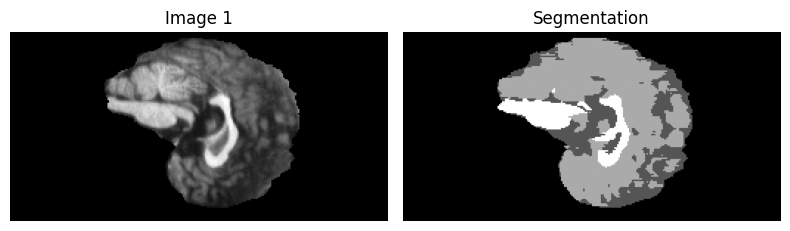

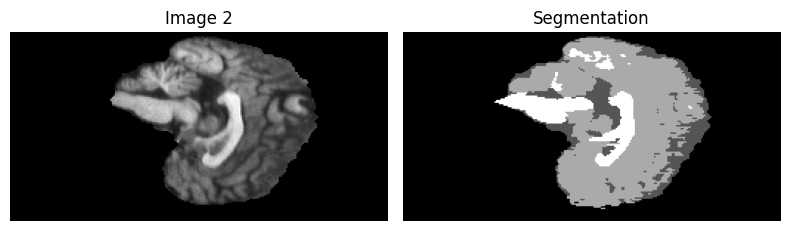

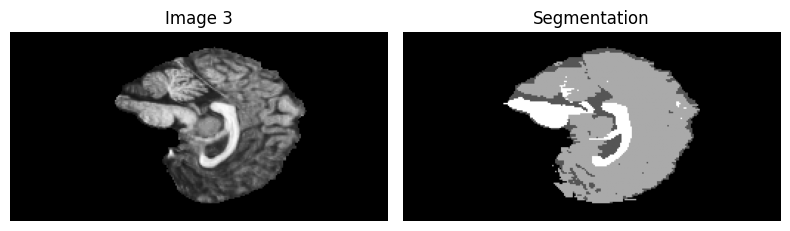

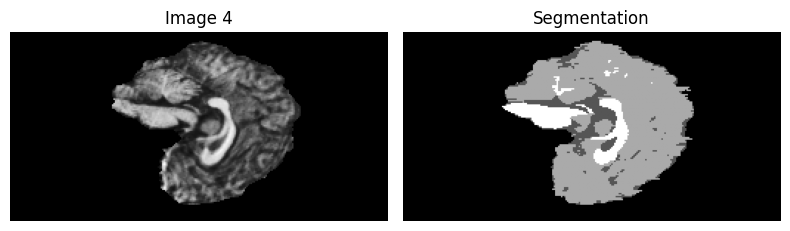

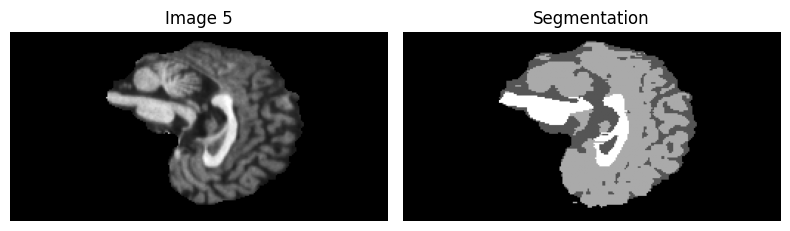

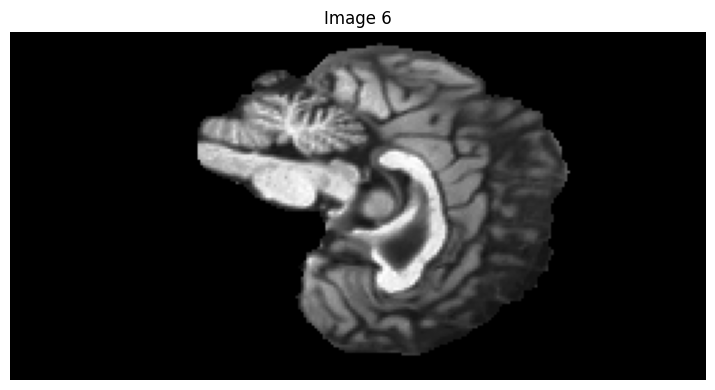

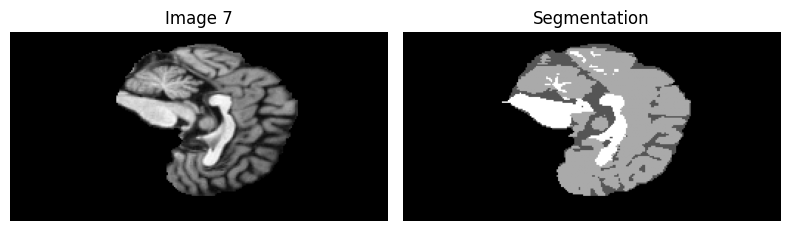

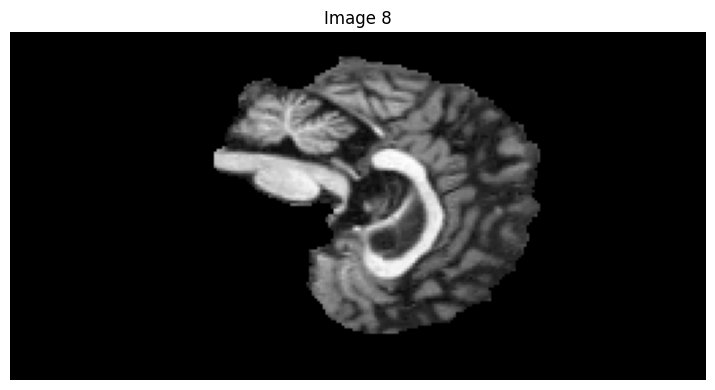

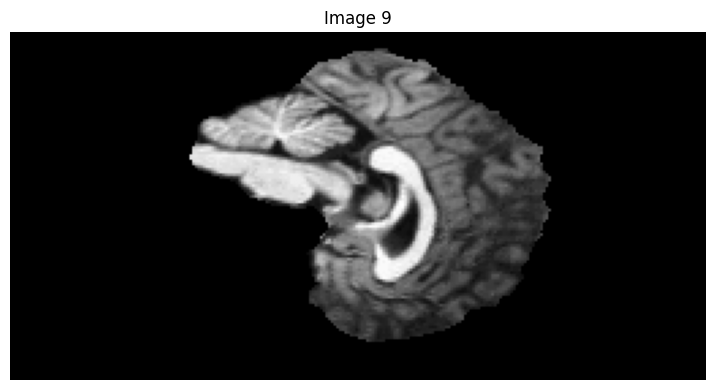

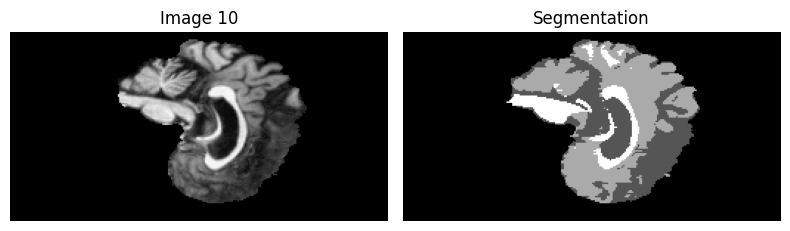

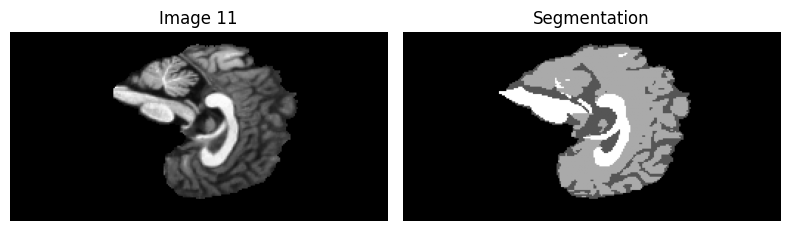

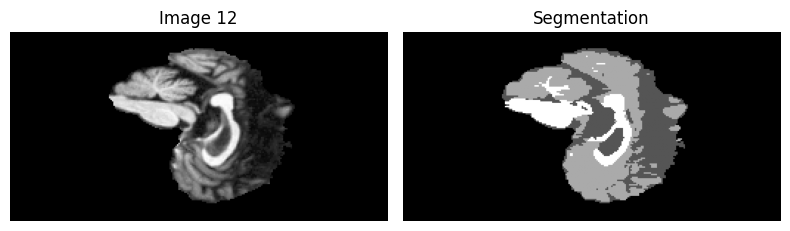

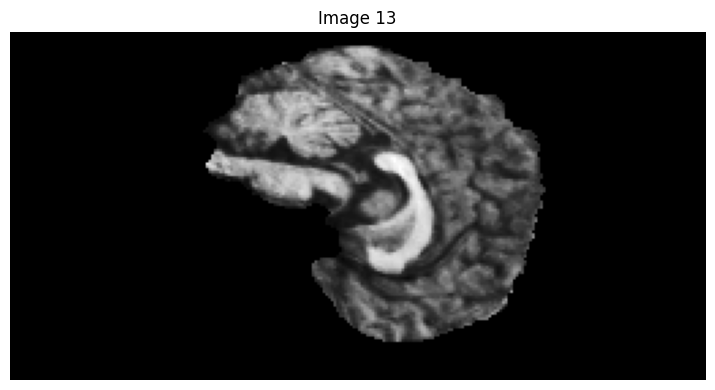

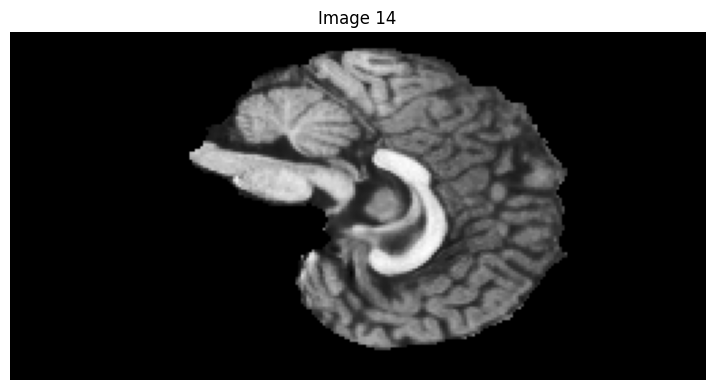

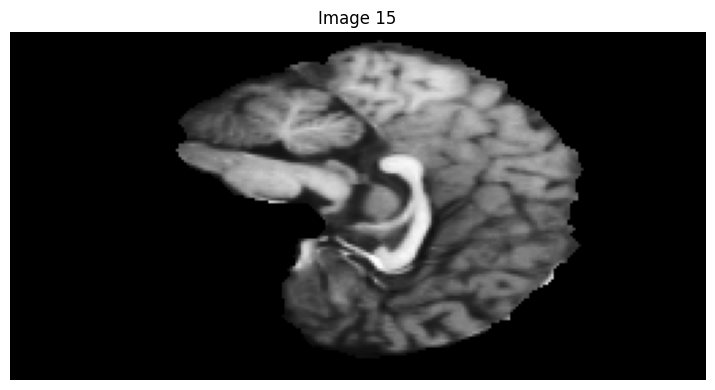

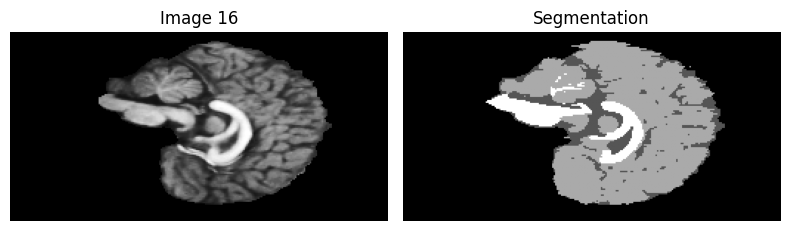

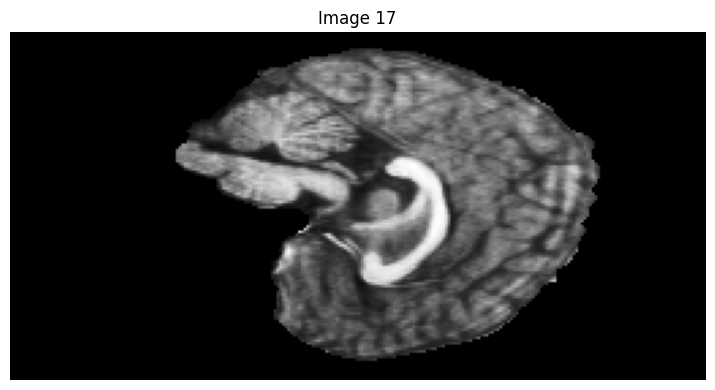

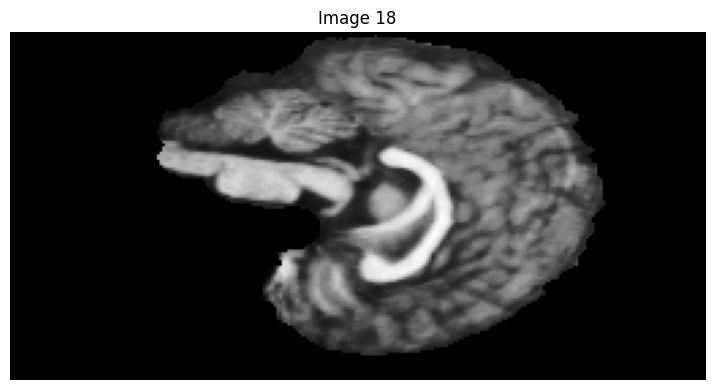

In [14]:
for i, item in enumerate(data):
    img = loader(item["img"])
    
    has_seg = "seg" in item
    fig, axs = plt.subplots(1, 2 if has_seg else 1, figsize=(8, 4))
    
    # Ensure axs is always a list for uniform access
    if not has_seg:
        axs = [axs]
    
    # Display the image (middle slice)
    axs[0].imshow(img[img.shape[0] // 2], cmap='gray')
    axs[0].set_title(f"Image {i+1}")
    axs[0].axis('off')

    # If segmentation exists, display it too
    if has_seg:
        seg = loader(item["seg"])
        axs[1].imshow(seg[seg.shape[0] // 2], cmap='gray')
        axs[1].set_title("Segmentation")
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()


### SPLITTING INTO TRAIN AND VALID FOR SEG AVAILABLE

In [15]:
# Filters data to keep only entries that contain a segmentation path.
data_seg_available = list(filter(lambda d: "seg" in d.keys(), data))

# Filters data to keep entries that only have an image (no "seg" key).
data_seg_unavailable = list(filter(lambda d: "seg" not in d.keys(), data))

# Splits data_seg_available into:
# 80% for training
# 20% for validation
data_seg_available_train, data_seg_available_valid = monai.data.utils.partition_dataset(
    data_seg_available, ratios=(8, 2) # 80/20
)
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. definitely skip validation here if there's just one segmentation label.

print(f"Number of data items with segmentation labels: {len(data_seg_available)}")
print(f"Number of data items with segmentation labels for training: {len(data_seg_available_train)}")
print(f"Number of data items with segmentation labels for validation: {len(data_seg_available_valid)}")
print(f"Number of data items without segmentation labels: {len(data_seg_unavailable)}")


Number of data items with segmentation labels: 10
Number of data items with segmentation labels for training: 8
Number of data items with segmentation labels for validation: 2
Number of data items without segmentation labels: 8


### DEFINING TRANSFORMATION PARAMETER

In [16]:
transform_seg_available = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=["img", "seg"], image_only=True),
        monai.transforms.EnsureChannelFirstD(keys=["img", "seg"]),
        monai.transforms.EnsureTypeD(keys=["img", "seg"]),
        monai.transforms.TransposeD(keys=["img", "seg"], indices=(0,1,2,3)),
        (
            monai.transforms.ResizeD(
                keys=["img", "seg"],
                spatial_size=(resize, resize, resize),
                mode=["trilinear", "nearest"],
                align_corners=[False, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

### CREATING CACHE TRAINING AND VALIDATION DATASET

In [17]:
dataset_seg_available_train = monai.data.CacheDataset(
    data=data_seg_available_train, transform=transform_seg_available, cache_num=4 # 16
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data=data_seg_available_valid, transform=transform_seg_available, cache_num=4 # 16
)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


### CREATING A SEGMENTATION NETWORK

In [18]:
seg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    1,  # input channels
    num_segmentation_classes,  # output channels
    (8, 16, 16, 32, 32, 64, 64),  # channel sequence
    (1, 2, 1, 2, 1, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)

### COMPUTING A FORWARD PASS

In [19]:
data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 96, 96, 96])
Shape of seg_net output: torch.Size([1, 4, 96, 96, 96])


### DEFINING LOSS FUNCTION

In [20]:
dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,  # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True,  # Note that our segmentation network is missing the softmax at the end
    reduction="mean",
)

dice_loss2 = monai.losses.DiceLoss(include_background=True, to_onehot_y=False, softmax=False, reduction="mean")

### CREATING A DATALOADER

In [21]:
dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train, batch_size=4, num_workers=0, shuffle=True #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 8
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid, batch_size=4, num_workers=0, shuffle=False #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 16
)

### DSC ADDED

In [22]:
dice_metric_train = DiceMetric(include_background=True, reduction="none", get_not_nans=True)
dice_metric_val = DiceMetric(include_background=True, reduction="none", get_not_nans=True)

### SEG TRAIN

Epoch 1/60:
	training loss: 0.8148524165153503
train_dice_scores shape: torch.Size([8, 4])
		Class 0: Dice = 0.6403
		Class 1: Dice = 0.0139
		Class 2: Dice = 0.4226
		Class 3: Dice = 0.0425
	validation loss: 0.8011953830718994
	Per-class Dice scores:
		Class 0: Dice = 0.9525
		Class 1: Dice = 0.0070
		Class 2: Dice = 0.6898
		Class 3: Dice = 0.0256
Epoch 2/60:
	training loss: 0.7688773274421692
train_dice_scores shape: torch.Size([8, 4])
		Class 0: Dice = 0.9368
		Class 1: Dice = 0.0313
		Class 2: Dice = 0.6083
		Class 3: Dice = 0.0851
	validation loss: 0.7805631160736084
	Per-class Dice scores:
		Class 0: Dice = 0.9745
		Class 1: Dice = 0.0088
		Class 2: Dice = 0.6931
		Class 3: Dice = 0.0183
Epoch 3/60:
	training loss: 0.7317485213279724
train_dice_scores shape: torch.Size([8, 4])
		Class 0: Dice = 0.9822
		Class 1: Dice = 0.0395
		Class 2: Dice = 0.6566
		Class 3: Dice = 0.0864
	validation loss: 0.7523045539855957
	Per-class Dice scores:
		Class 0: Dice = 0.9745
		Class 1: Dice = 0

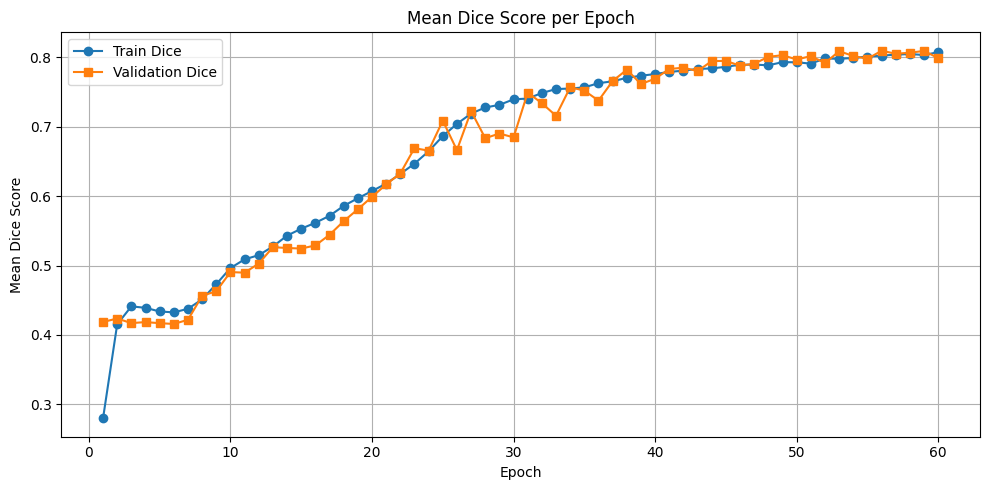

In [23]:
seg_net.to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

max_epochs = 60 # 60
training_losses = []
validation_losses = []
dice_scores_train = []
dice_scores_val = []
val_interval = 1

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")

    seg_net.train()
    dice_metric_train.reset()  # ← Add this here
    losses = []

    for batch in dataloader_seg_available_train:
        imgs = batch["img"].to(device)
        true_segs = batch["seg"].to(device)
        # print(true_segs.shape)
        # print(imgs.shape)

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # --- Dice Score Calculation for training ---
        predicted_labels = torch.argmax(torch.softmax(predicted_segs, dim=1), dim=1)
        num_classes = 4

        pred_onehot = one_hot(predicted_labels.long(), num_classes).permute(0, 4, 1, 2, 3).float()
        true_segs_squeezed = true_segs.long().squeeze(1)  # Remove channel dimension [B, 1, D, H, W] -> [B, D, H, W]
        true_onehot = one_hot(true_segs_squeezed, num_classes)  # shape [B, D, H, W, C]
        true_onehot = true_onehot.permute(0, 4, 1, 2, 3).float()  # [B, C, D, H, W]

        dice_metric_train(y_pred=pred_onehot, y=true_onehot)

    training_loss = np.mean(losses)
    print(f"\ttraining loss: {training_loss}")
    training_losses.append([epoch_number, training_loss])

    # Per-class Dice for training
    train_dice_scores, _ = dice_metric_train.aggregate()  # [num_samples, num_classes]
    train_dice_np = train_dice_scores.cpu().numpy()
    mean_per_class = train_dice_np.mean(axis=0)  # Average over samples (axis=0
    print("train_dice_scores shape:", train_dice_scores.shape)  # helpful to debug

    for class_idx, score in enumerate(mean_per_class):
        print(f"\t\tClass {class_idx}: Dice = {score:.4f}")

    mean_dice_train = mean_per_class.mean()
    dice_scores_train.append(mean_dice_train)

    if epoch_number % val_interval == 0:
        seg_net.eval()
        losses = []
        dice_metric_val.reset()  # Reset metric before validation loop
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

                # Convert predictions to class labels
                predicted_labels = torch.argmax(torch.softmax(predicted_segs, dim=1), dim=1)

                # Convert to one-hot for metric
                num_classes = predicted_segs.shape[1]
                pred_onehot = one_hot(predicted_labels.long(), num_classes=num_classes).permute(0, 4, 1, 2, 3).float()
                true_segs_squeezed = true_segs.long().squeeze(1)  # Remove channel dimension [B, 1, D, H, W] -> [B, D, H, W]
                true_onehot = one_hot(true_segs_squeezed, num_classes)  # shape [B, D, H, W, C]
                true_onehot = true_onehot.permute(0, 4, 1, 2, 3).float()  # [B, C, D, H, W]

                dice_metric_val(y_pred=pred_onehot, y=true_onehot)

        validation_loss = np.mean(losses)
        print(f"\tvalidation loss: {validation_loss}")
        validation_losses.append([epoch_number, validation_loss])

        # Compute per-class Dice score
        class_dice_scores, _ = dice_metric_val.aggregate()  # [num_samples, num_classes]
        print("\tPer-class Dice scores:")
        class_dice_np = class_dice_scores.cpu().numpy()
        mean_per_class_val = class_dice_np.mean(axis=0)  # Average over samples
        for class_idx, score in enumerate(mean_per_class_val):
            print(f"\t\tClass {class_idx}: Dice = {score:.4f}")
        mean_dice_val = mean_per_class_val.mean()
        dice_scores_val.append(mean_dice_val)

# Free up some memory
del loss, predicted_segs, true_segs, imgs
torch.cuda.empty_cache()

# ✅ Plot Mean Dice Scores
epochs = list(range(1, max_epochs + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, dice_scores_train, label='Train Dice', marker='o')
plt.plot(epochs, dice_scores_val, label='Validation Dice', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Mean Dice Score')
plt.title('Mean Dice Score per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### PLOTTING LOSS

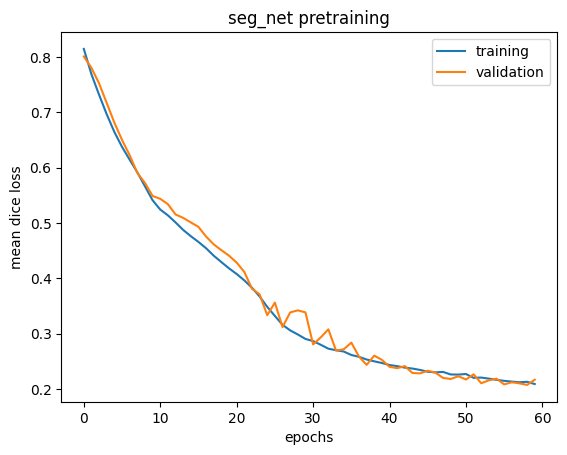

In [24]:
plot_against_epoch_numbers(training_losses, label="training")
plot_against_epoch_numbers(validation_losses, label="validation")
plt.legend()
plt.ylabel("mean dice loss")
plt.title("seg_net pretraining")
plt.savefig("seg_net_pretrained_losses.png")
plt.show()

### SAVING MODEL

In [25]:
torch.save(seg_net.state_dict(), "seg_net_pretrained.pth")

### LOADING MODEL

In [26]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net_pretrained.pth', weights_only=True))

### TO RUN PRETRAINED SEG NET MODEL

Original image from validation set:


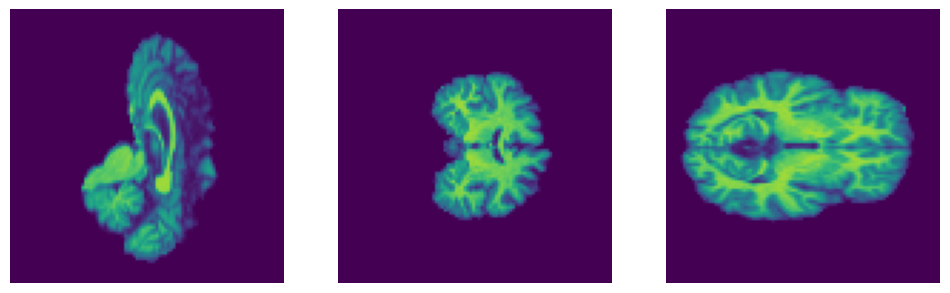

Ground truth segmentation:


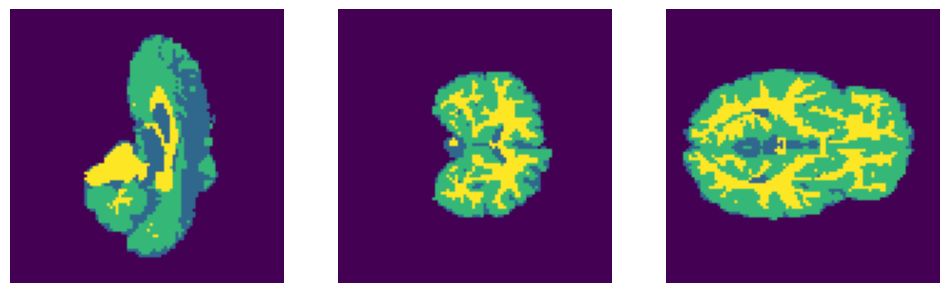

Our predicted segmentation:


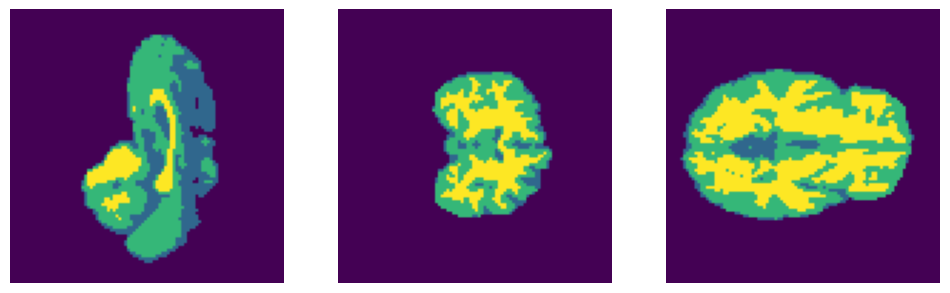

In [27]:
seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item["img"]
test_seg_true = data_item["seg"]
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()

print("Original image from validation set:")
preview_image(test_input[0])
print("Ground truth segmentation:")
preview_image(test_seg_true[0])
print("Our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])

del test_seg_predicted
torch.cuda.empty_cache()

### CREATING A VALIDATION SAFE DATASET FOR COMBINED MODEL

In [28]:
data_without_seg_valid = data_seg_unavailable + data_seg_available_train  # Note the order

### SPLITTING THE DATASET FOR REGISTRATION NETWORK

In [29]:
data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid, ratios=(2, 8), shuffle=False  # 20% VALID AND 80% TRAIN
)

### GENERATING ALL POSSIBLE PAIRS 

In [30]:
def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_limit = len(data) if symmetric else i
        for j in range(j_limit):
            if j == i:
                continue
            d1 = data[i]
            d2 = data[j]
            pair = {"img1": d1["img"], "img2": d2["img"]}
            if "seg" in d1.keys():
                pair["seg1"] = d1["seg"]
            if "seg" in d2.keys():
                pair["seg2"] = d2["seg"]
            data_pairs.append(pair)
    return data_pairs


data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

### CATEGORIZING INTO 4 GROUPS BASED ON 

| Key    | Meaning                                                                   |
| ------ | ------------------------------------------------------------------------- |
| `"00"` | Neither `img1` nor `img2` has a segmentation (`seg1`, `seg2` not present) |
| `"01"` | Only `img2` has a segmentation (`seg2` exists, `seg1` does not)           |
| `"10"` | Only `img1` has a segmentation (`seg1` exists, `seg2` does not)           |
| `"11"` | Both `img1` and `img2` have segmentations (`seg1` and `seg2` exist)       |


In [31]:
def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {"00": [], "01": [], "10": [], "11": []}
    for d in data_pairs_list:
        if "seg1" in d.keys() and "seg2" in d.keys():
            out_dict["11"].append(d)
        elif "seg1" in d.keys():
            out_dict["10"].append(d)
        elif "seg2" in d.keys():
            out_dict["01"].append(d)
        else:
            out_dict["00"].append(d)
    return out_dict

data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

# Print each group on a new line
print("Training Pairs Subdivided:")
for key, value in data_pairs_train_subdivided.items():
    print(f"{key}: {len(value)} pairs")


Training Pairs Subdivided:
00: 20 pairs
01: 40 pairs
10: 40 pairs
11: 56 pairs


### SOME USEFUL INFO

In [32]:
# print some useful counts to be aware of
num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = (
    len(data_pairs_train_subdivided["01"])
    + len(data_pairs_train_subdivided["10"])
    + len(data_pairs_train_subdivided["11"])
)

print(f"""We have {num_train_both} pairs to train reg_net and seg_net together,
  and an additional {num_train_reg_net - num_train_both} to train reg_net alone.""")
print(f"We have {num_valid_reg_net} pairs for reg_net validation.")

We have 136 pairs to train reg_net and seg_net together,
  and an additional 20 to train reg_net alone.
We have 6 pairs for reg_net validation.


### TRANSFORMATION PARAMETER FOR REGISTRATION

In [33]:
def unsqueeze_if_needed(x):
    # Squeeze last dim if it's singleton channel dim
    if x.ndim == 3:
        return x.unsqueeze(3)
    return x

transform_pair = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=["img1", "seg1", "img2", "seg2"], image_only=True, allow_missing_keys=True),
        monai.transforms.LambdaD(keys=["img1", "seg1", "img2", "seg2"], func=unsqueeze_if_needed, allow_missing_keys=True),
        monai.transforms.TransposeD(keys=["img1", "seg1", "img2", "seg2"], indices=(3,2, 1, 0), allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=["img1", "img2"], name="img12", dim=0),
        monai.transforms.DeleteItemsD(keys=["img1", "img2"]),
        (
            monai.transforms.ResizeD(
                keys=["img12", "seg1", "seg2"],
                spatial_size=(96, 96, 96),
                mode=["trilinear", "nearest", "nearest"],
                allow_missing_keys=True,
                align_corners=[False, None, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

### CREATING CACHE DATASET FOR ``` 00 01 10 11 ```

In [34]:
dataset_pairs_train_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=4) # 32
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}

dataset_pairs_valid_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=4) # 32
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}

Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


### DEFINING REGISTRATION MODEL

In [35]:
# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.VoxelMorphUNet(
    3,  # spatial dims
    2,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 64, 64, 32, 32, 16),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)

### TRYING A FORWARD PASS

In [36]:
def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:], datasets[0])
    return random.choice(datasets_combined)

data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_input = data_item["img12"].unsqueeze(0)
reg_net_example_output = reg_net(reg_net_example_input)
print(f"Shape of reg_net input: {reg_net_example_input.shape}")
print(f"Shape of reg_net output: {reg_net_example_output.shape}")
image_scale = reg_net_example_input.shape[-1]  # comes in handy later

Shape of reg_net input: torch.Size([1, 2, 96, 96, 96])
Shape of reg_net output: torch.Size([1, 3, 96, 96, 96])


### USING PREDICTED DISPLACEMENT FIELD FROM REG NETWORK TO SPATIALLY WARP 3D IMAGE

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


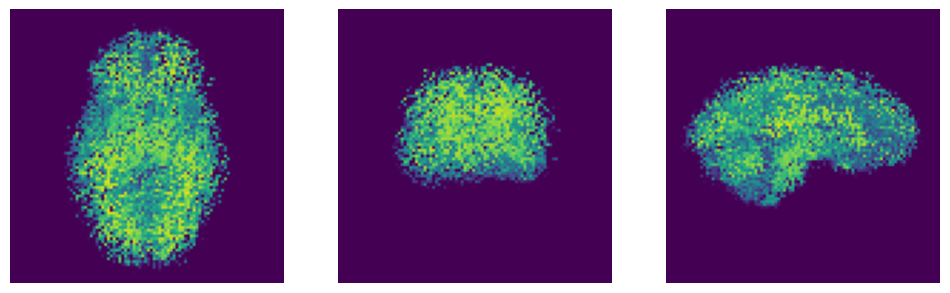

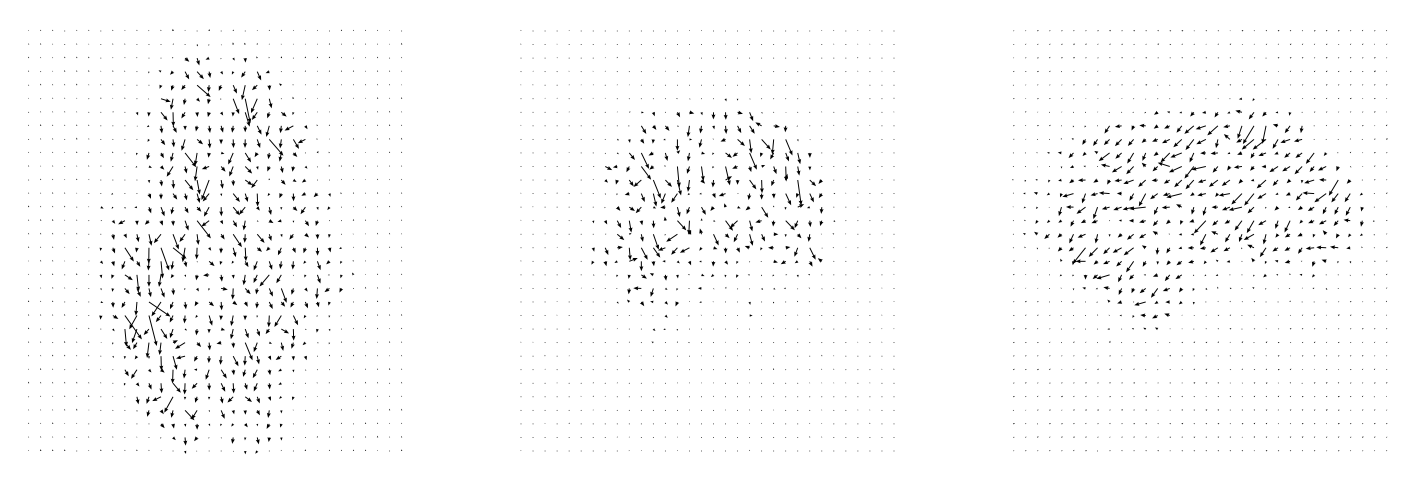

In [37]:
# For warping segmentation labels or class predictions, we sometimes want to use nearest neighbor interpolation
# Note that "bilinear" means "trilinear" in the case of 3D images
warp = monai.networks.blocks.Warp(mode="bilinear", padding_mode="border")
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="border")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item["img12"][[1], :, :, :].unsqueeze(0), reg_net_example_output  # moving image  # warping
)

# Previewing warped image
preview_image(example_warped_image[0,0].detach())

# Previewing displacement field
preview_3D_vector_field(reg_net_example_output.detach()[0])

### DEFINING 3D LOCAL NORMALIZED CROSS-CORRELATION LOSS FUNCTION

In [38]:
lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3, kernel_size=3, kernel_type="rectangular", reduction="mean"
)

In [39]:
bending_loss = monai.losses.BendingEnergyLoss()

### ENABLING TRAINING FOR ONE NETWORK AND FREEZING THE OTHER WHILE JOINT TRAINING

In [40]:
# While training for one network we dont want to computer gradients for the other network
def swap_training(network_to_train, network_to_not_train):
    """
    Switch out of training one network and into training another
    """
    for param in network_to_not_train.parameters():
        param.requires_grad = False

    for param in network_to_train.parameters():
        param.requires_grad = True

    network_to_not_train.eval()
    network_to_train.train()

### DEFINING LOSS

In [41]:
regularization_loss = bending_loss

def similarity_loss(displacement_field, image_pair):
    """Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D)."""
    warped_img2 = warp(image_pair[:, [1], :, :, :], displacement_field)
    return lncc_loss(warped_img2, image_pair[:, [0], :, :, :])  # prediction  # target

def anatomy_loss(displacement_field, image_pair, seg_net, gt_seg1=None, gt_seg2=None):
    """
    Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D).
    seg_net is the model used to segment an image,
      mapping (B,1,H,W,D) to (B,C,H,W,D) where C is the number of segmentation classes.
    gt_seg1 and gt_seg2 are ground truth segmentations for the images in image_pair, if ground truth is available;
      if unavailable then they can be None.
      gt_seg1 and gt_seg2 are expected to be in the form of class labels, with shape (B,1,H,W,D).
    """
    if gt_seg1 is not None:
        # ground truth seg of target image
        seg1 = monai.networks.one_hot(gt_seg1, num_segmentation_classes)
    else:
        # seg_net on target image, "noisy ground truth"
        seg1 = seg_net(image_pair[:, [0], :, :, :]).softmax(dim=1)

    if gt_seg2 is not None:
        # ground truth seg of moving image
        seg2 = monai.networks.one_hot(gt_seg2, num_segmentation_classes)
    else:
        # seg_net on moving image, "noisy ground truth"
        seg2 = seg_net(image_pair[:, [1], :, :, :]).softmax(dim=1)

    # seg1 and seg2 are now in the form of class probabilities at each voxel
    # The trilinear interpolation of the function `warp` is then safe to use;
    # it will preserve the probabilistic interpretation of seg2.

    return dice_loss2(
        warp(seg2, displacement_field), seg1  # warp of moving image segmentation  # target image segmentation
    )

### Function for forward pass of reg_net, to avoid duplicating code between training and validation

In [42]:
def reg_losses(batch):
    img12 = batch["img12"].to(device)

    displacement_field12 = reg_net(img12)

    loss_sim = similarity_loss(displacement_field12, img12)

    loss_reg = regularization_loss(displacement_field12)

    gt_seg1 = batch["seg1"].to(device) if "seg1" in batch.keys() else None
    gt_seg2 = batch["seg2"].to(device) if "seg2" in batch.keys() else None
    loss_ana = anatomy_loss(displacement_field12, img12, seg_net, gt_seg1, gt_seg2)

    return loss_sim, loss_reg, loss_ana

### CREATING A SEPERATE DATALOADERS FOR EACH SUBGROUP OF TRAINING AND VALIDATION DATASET BASED ON SEGMENTATION AVAILABILITY LABLES

``` ('00', '10', '01', '11') ```

ELSE 

ASSIGNING AN EMPTY LIST IF THE SUB GROUP IS EMPTY

In [43]:
# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI dataloaders

dataloader_pairs_train_subdivided = {
    seg_availability: (
        monai.data.DataLoader(dataset, batch_size=2, num_workers=0, shuffle=True) if len(dataset) > 0 else [] # Number of workers can be set to 4 for better performance
    )  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_train_subdivided.items()
}

dataloader_pairs_valid_subdivided = {
    seg_availability: (
        monai.data.DataLoader(
            dataset,
            batch_size=4,
            num_workers=0, # 4
            shuffle=True,  # Shuffle validation data because we will only take a sample for validation each time
        )
        if len(dataset) > 0
        else []
    )  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_valid_subdivided.items()
}

### CREATING A BATCH GENERATOR

In [44]:
seg_availabilities = ["00", "01", "10", "11"]


def create_batch_generator(dataloader_subdivided, weights=None):
    """
    Create a batch generator that samples data pairs with various segmentation availabilities.

    Arguments:
        dataloader_subdivided : a mapping from the labels in seg_availabilities to dataloaders
        weights : a list of probabilities, one for each label in seg_availabilities;
                  if not provided then we weight by the number of data items of each type,
                  effectively sampling uniformly over the union of the datasets

    Returns: batch_generator
        A function that accepts a number of batches to sample and that returns a generator.
        The generator will weighted-randomly pick one of the seg_availabilities and
        yield the next batch from the corresponding dataloader.
    """
    if weights is None:
        weights = np.array([len(dataloader_subdivided[s]) for s in seg_availabilities])
    weights = np.array(weights)
    weights = weights / weights.sum()
    dataloader_subdivided_as_iterators = {s: iter(d) for s, d in dataloader_subdivided.items()}

    def batch_generator(num_batches_to_sample):
        for _ in range(num_batches_to_sample):
            seg_availability = np.random.choice(seg_availabilities, p=weights)
            try:
                yield next(dataloader_subdivided_as_iterators[seg_availability])
            except StopIteration:  # If dataloader runs out, restart it
                dataloader_subdivided_as_iterators[seg_availability] = iter(dataloader_subdivided[seg_availability])
                yield next(dataloader_subdivided_as_iterators[seg_availability])

    return batch_generator

In [45]:
batch_generator_train_reg = create_batch_generator(dataloader_pairs_train_subdivided)
batch_generator_valid_reg = create_batch_generator(dataloader_pairs_valid_subdivided)


# When training seg_net alone, we only consider data pairs for which at least one ground truth seg is available
seg_train_sampling_weights = [0] + [len(dataloader_pairs_train_subdivided[s]) for s in seg_availabilities[1:]]
print(
    f"""When training seg_net alone, segmentation availabilities {seg_availabilities}
will be sampled with respective weights {seg_train_sampling_weights}"""
)
batch_generator_train_seg = create_batch_generator(dataloader_pairs_train_subdivided, seg_train_sampling_weights)

When training seg_net alone, segmentation availabilities ['00', '01', '10', '11']
will be sampled with respective weights [0, 20, 20, 28]


### DSC FOR BOTH

In [ ]:
from monai.metrics import DiceMetric

dice_metric = DiceMetric(include_background=False, reduction="mean")

### TRAINING BOTH SEG AND REG MODEL

In [47]:
# Training cell
# (if already done then you may skip this and uncomment the loading checkpoint cell below)

seg_net.to(device)
reg_net.to(device)

learning_rate_reg = 5e-4
optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

learning_rate_seg = 1e-3
optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

lambda_a = 2.0  # anatomy loss weight
lambda_sp = 3.0  # supervised segmentation loss weight

# regularization loss weight
# This often requires some careful tuning. Here we suggest a value, which unfortunately needs to
# depend on image scale. This is because the bending energy loss is not scale-invariant.
# 7.5 worked well with the above hyperparameters for images of size 128x128x128.
lambda_r = 7.5 * (image_scale / 128) ** 2

max_epochs = 5 # 120
reg_phase_training_batches_per_epoch = 5 #40 
seg_phase_training_batches_per_epoch = 1 #5  # Fewer batches needed, because seg_net converges more quickly
reg_phase_num_validation_batches_to_use = 5 #40
val_interval = 1 # 5

training_losses_reg = []
validation_losses_reg = []
training_losses_seg = []
validation_losses_seg = []
dice_scores_train = []
dice_scores_val = []

best_seg_validation_loss = float("inf")
best_reg_validation_loss = float("inf")

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")

    # ------------------------------------------------
    #         reg_net training, with seg_net frozen
    # ------------------------------------------------

    # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
    swap_training(reg_net, seg_net)

    losses = []
    for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
        optimizer_reg.zero_grad()
        loss_sim, loss_reg, loss_ana = reg_losses(batch)
        loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
        loss.backward()
        optimizer_reg.step()
        losses.append(loss.item())

    training_loss = np.mean(losses)
    print(f"\treg training loss: {training_loss}")
    training_losses_reg.append([epoch_number, training_loss])

    if epoch_number % val_interval == 0:
        reg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
                loss_sim, loss_reg, loss_ana = reg_losses(batch)
                loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\treg validation loss: {validation_loss}")
        validation_losses_reg.append([epoch_number, validation_loss])

        if validation_loss < best_reg_validation_loss:
            best_reg_validation_loss = validation_loss
            torch.save(reg_net.state_dict(), "reg_net_best.pth")

    # Free up memory
    del loss, loss_sim, loss_reg, loss_ana
    torch.cuda.empty_cache()

    # ------------------------------------------------
    #         seg_net training, with reg_net frozen
    # ------------------------------------------------

    # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
    swap_training(seg_net, reg_net)

    dice_metric_train.reset()  # ← MEEEEEEEEEEEEEEEEEEEEEEE
    losses = []
    for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
        optimizer_seg.zero_grad()

        img12 = batch["img12"].to(device)

        displacement_fields = reg_net(img12)
        seg1_predicted = seg_net(img12[:, [0], :, :, :]).softmax(dim=1)
        seg2_predicted = seg_net(img12[:, [1], :, :, :]).softmax(dim=1)

        # Below we compute the following:
        # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
        # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
        # loss_metric: a single supervised seg loss, as a metric to track the progress of training

        if "seg1" in batch.keys() and "seg2" in batch.keys():
            seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
            seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg2_predicted, seg2)
            loss_supervised = dice_loss2(seg1_predicted, seg1) + loss_metric
            # The above supervised loss looks a bit different from the one in the paper
            # in that it includes predictions for both images in the current image pair;
            # we might as well do this, since we have gone to the trouble of loading
            # both segmentations into memory.
            # Update DSC metric for seg1 and seg2
            dice_metric(seg1_predicted, seg1)
            dice_metric(seg2_predicted, seg2)

        elif "seg1" in batch.keys():  # seg1 available, but no seg2
            seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg1_predicted, seg1)
            loss_supervised = loss_metric
            seg2 = seg2_predicted  # Use this in anatomy loss
            # Update DSC metric for seg1 only
            dice_metric(seg1_predicted, seg1)

        else:  # seg2 available, but no seg1
            assert "seg2" in batch.keys()
            seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg2_predicted, seg2)
            loss_supervised = loss_metric
            seg1 = seg1_predicted  # Use this in anatomy loss
            # Update DSC metric for seg2 only
            dice_metric(seg2_predicted, seg2)

        # seg1 and seg2 should now be in the form of one-hot class probabilities

        loss_anatomy = (
            dice_loss2(warp_nearest(seg2, displacement_fields), seg1)
            if "seg1" in batch.keys() or "seg2" in batch.keys()
            else 0.0
        )  # It wouldn't really be 0, but it would not contribute to training seg_net

        # (If you want to refactor this code for *joint* training of reg_net and seg_net,
        #  then use the definition of anatomy loss given in the function anatomy_loss above,
        #  where differentiable warping is used and reg net can be trained with it.)

        loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
        loss.backward()
        optimizer_seg.step()

        losses.append(loss_metric.item())

    training_loss = np.mean(losses)
    mean_dice = dice_metric.aggregate().item()  # Get mean DSC over batches
    print(f"\tseg training loss: {training_loss}")
    training_losses_seg.append([epoch_number, training_loss])
    dice_scores_train.append([epoch_number, mean_dice])
    dice_metric.reset()  # reset metric after each epoch

    if epoch_number % val_interval == 0:
        # The following validation loop would not do anything in the case
        # where there is just one segmentation available,
        # because data_seg_available_valid would be empty.
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\tseg validation loss: {validation_loss}")
        validation_losses_seg.append([epoch_number, validation_loss])

        if validation_loss < best_seg_validation_loss:
            best_seg_validation_loss = validation_loss
            torch.save(seg_net.state_dict(), "seg_net_best.pth")

    # Free up memory
    del (
        loss,
        seg1,
        seg2,
        displacement_fields,
        img12,
        loss_supervised,
        loss_anatomy,
        loss_metric,
        seg1_predicted,
        seg2_predicted,
    )
    torch.cuda.empty_cache()

print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")
print(f"Best seg_net validation loss: {best_seg_validation_loss}")

Epoch 1/5:
	reg training loss: 13.711238288879395
	reg validation loss: -204.6436312317848
	seg training loss: 0.2200162410736084
	seg validation loss: 0.2957381010055542
Epoch 2/5:
	reg training loss: 11.823412704467774
	reg validation loss: -139.73407930135727
	seg training loss: 0.2607351243495941
	seg validation loss: 0.2663407325744629
Epoch 3/5:
	reg training loss: 10.424098587036132
	reg validation loss: -149.88770736455916
	seg training loss: 0.23397397994995117
	seg validation loss: 0.310848593711853
Epoch 4/5:
	reg training loss: 9.154990196228027
	reg validation loss: -133.93252017498017
	seg training loss: 0.25792086124420166
	seg validation loss: 0.2540023922920227
Epoch 5/5:
	reg training loss: 7.641296291351319
	reg validation loss: -214.35947778224946
	seg training loss: 0.21667301654815674
	seg validation loss: 0.21802154183387756


Best reg_net validation loss: -214.35947778224946
Best seg_net validation loss: 0.21802154183387756


### DSC PLOTTING

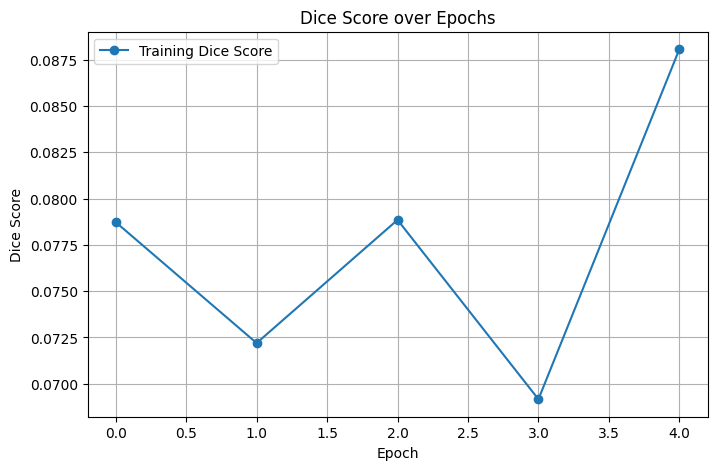

In [48]:
# Convert dice_scores_train and dice_scores_val to lists of epochs and scores
epochs_train = [e[0] for e in dice_scores_train]
dices_train = [e[1] for e in dice_scores_train]

# If you also track validation dice scores in dice_scores_val, do the same:
epochs_val = [e[0] for e in dice_scores_val]
dices_val = [e[1] for e in dice_scores_val]

plt.figure(figsize=(8,5))
plt.plot(epochs_train, dices_train, label="Training Dice Score", marker='o')

# Plot validation dice if available
if len(dice_scores_val) > 0:
    plt.plot(epochs_val, dices_val, label="Validation Dice Score", marker='o')

plt.title("Dice Score over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()
plt.grid(True)
plt.show()


### PLOTTING THE LOSS

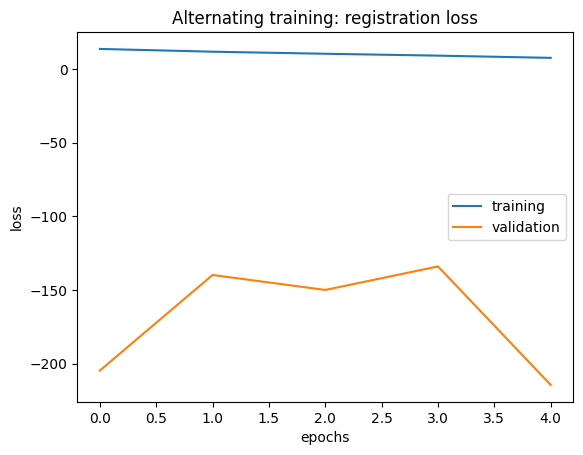

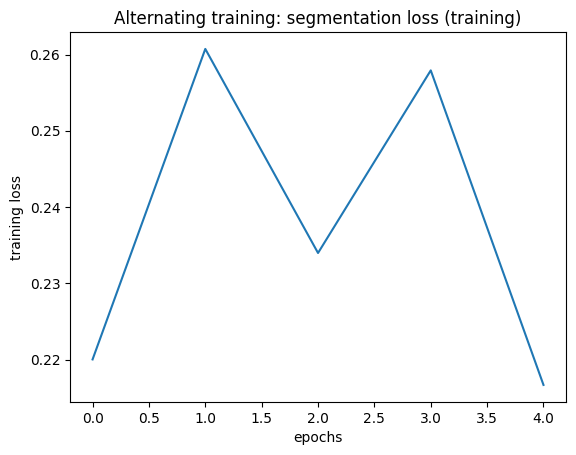

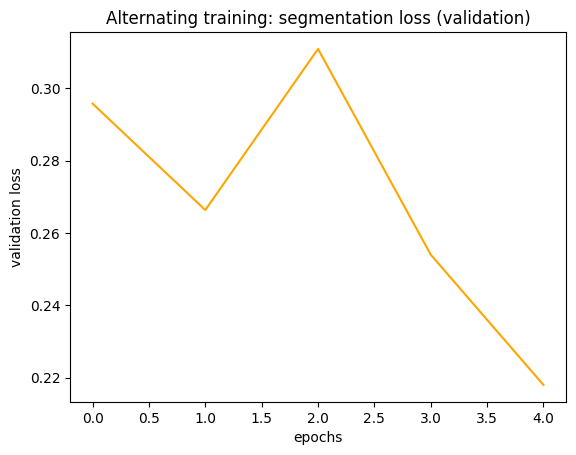

In [49]:
# Plot the training and validation losses

plot_against_epoch_numbers(training_losses_reg, label="training")
plot_against_epoch_numbers(validation_losses_reg, label="validation")
plt.legend()
plt.ylabel("loss")
plt.title("Alternating training: registration loss")
plt.savefig("reg_net_losses.png")
plt.show()

plot_against_epoch_numbers(training_losses_seg, label="training")
plt.ylabel("training loss")
plt.title("Alternating training: segmentation loss (training)")
plt.savefig("seg_net_training_losses.png")
plt.show()

plot_against_epoch_numbers(validation_losses_seg, label="validation", color="orange")
plt.ylabel("validation loss")
plt.title("Alternating training: segmentation loss (validation)")
plt.savefig("seg_net_validation_losses.png")
plt.show()

### SAVE

In [50]:
# CHECKPOINT CELL; SAVE
torch.save(seg_net.state_dict(), "seg_net.pth")
torch.save(reg_net.state_dict(), "reg_net.pth")

### LOAD

In [51]:
# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net.pth', weights_only=True))
# reg_net.load_state_dict(torch.load('reg_net.pth', weights_only=True))

### Run this cell to try out seg net on a random validation pair

original image from validation set:


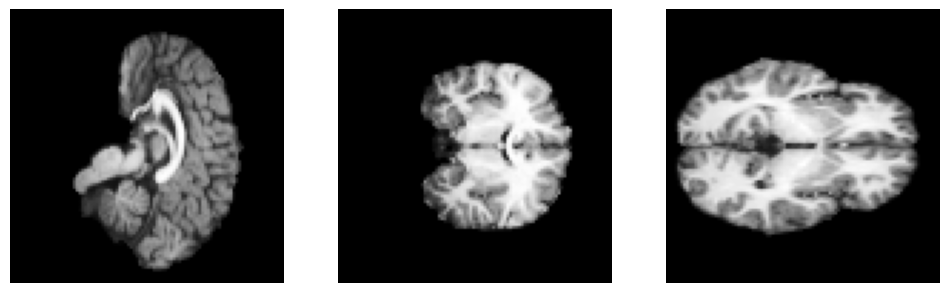

ground truth segmentation:


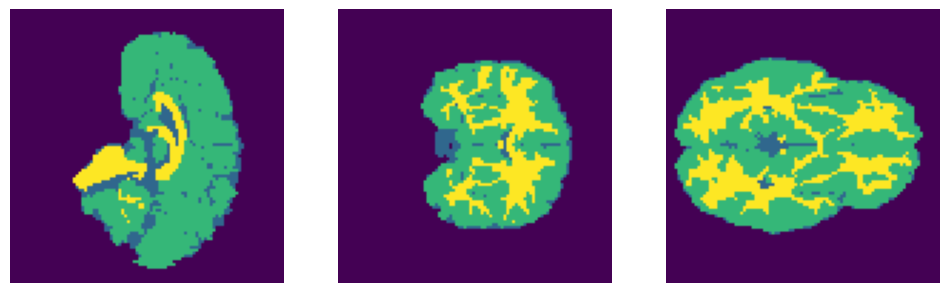

our predicted segmentation:


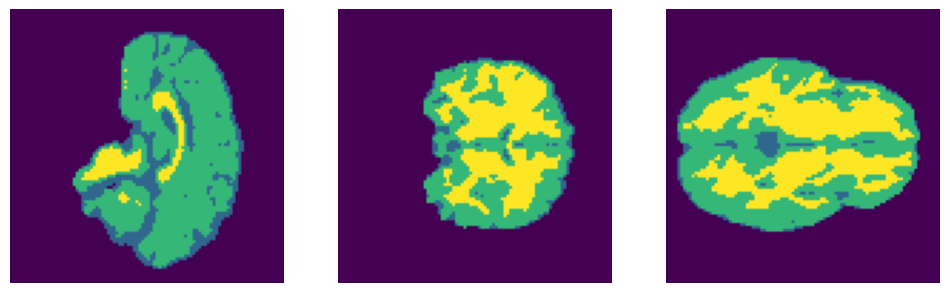

dice loss: 0.2293803095817566


In [52]:
seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item["img"]
test_seg_true = data_item["seg"]
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()
    loss = dice_loss(test_seg_predicted, test_seg_true.unsqueeze(0)).item()

print("original image from validation set:")
preview_image(test_input[0], normalize_by="slice", cmap="gray")
print("ground truth segmentation:")
preview_image(test_seg_true[0])
print("our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])
print(f"dice loss: {loss}")

del test_seg_predicted
torch.cuda.empty_cache()

### Run this cell to try out reg net on a random validation pair

moving image:


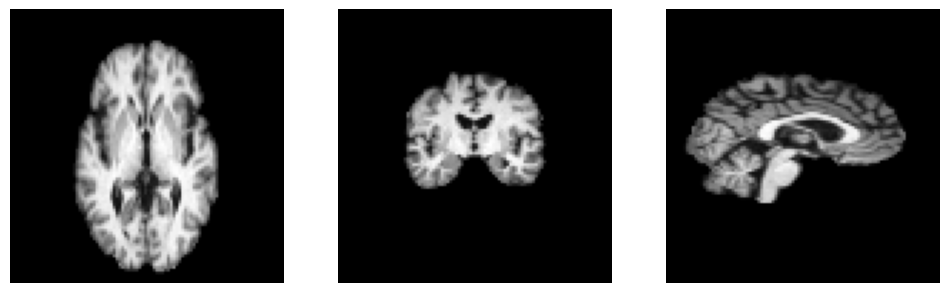

target image:


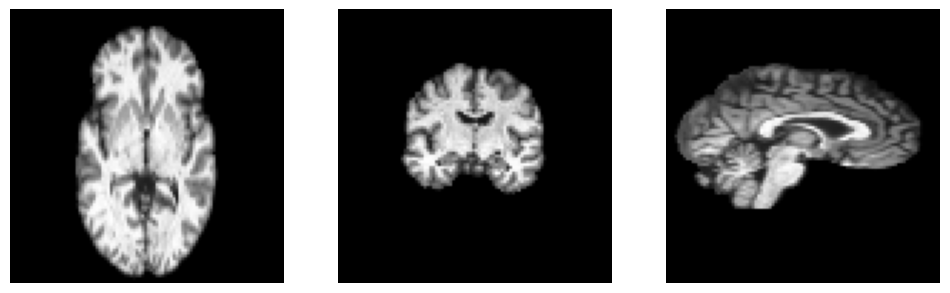

warped moving image:


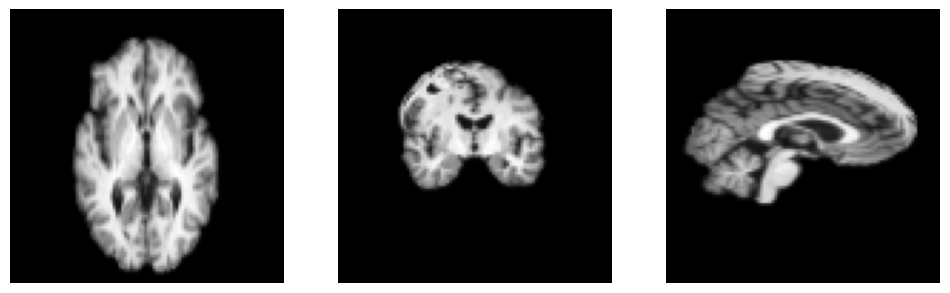

deformation vector field, projected into viewing planes:


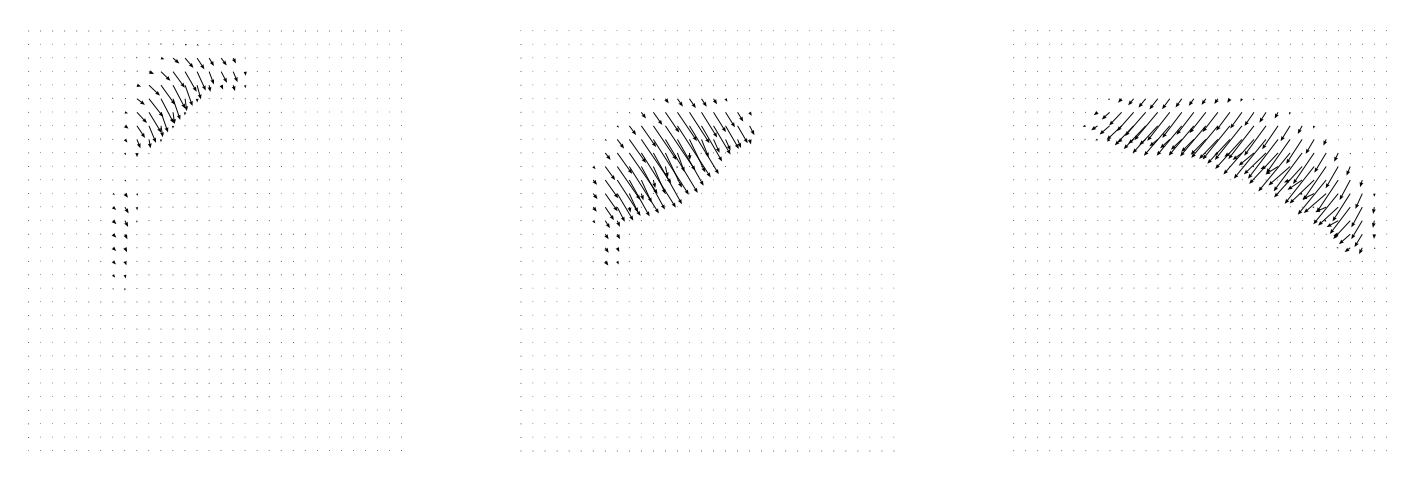

deformation applied to a grid, projected into viewing planes:


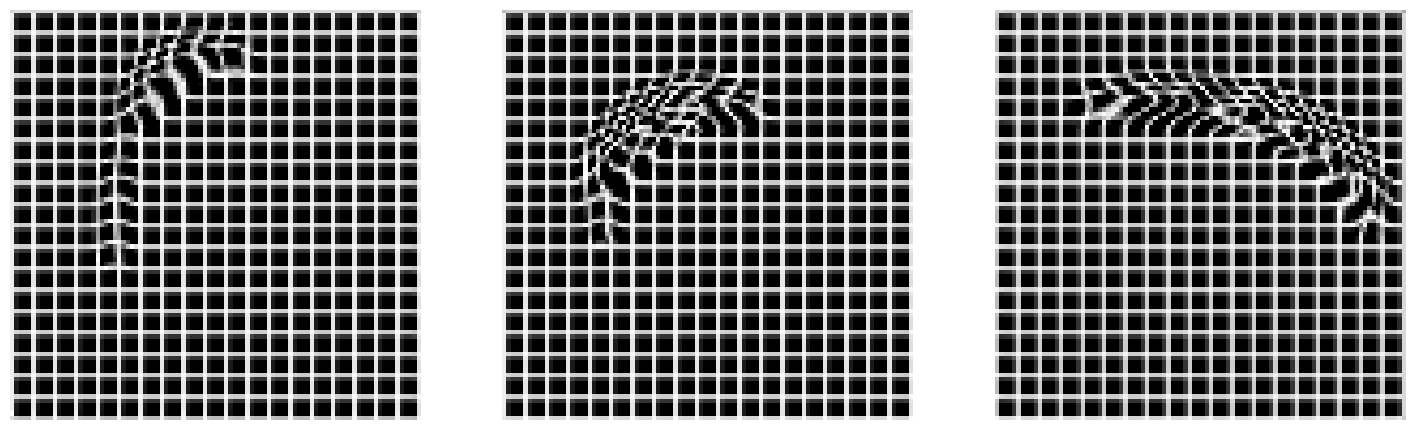

jacobian determinant:


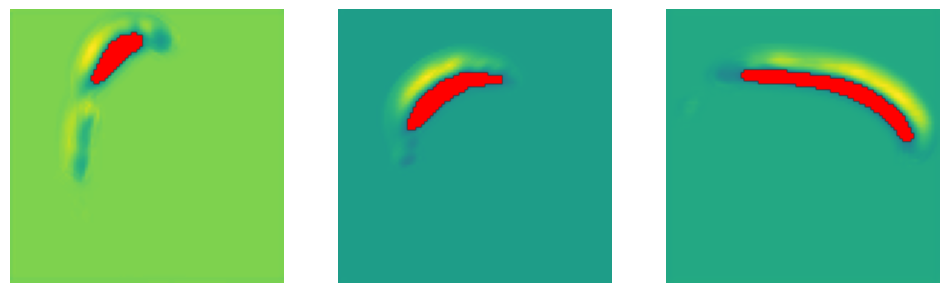

Similarity loss: -0.038837652653455734
number of folds: 13360


In [53]:
reg_net.to(device)
reg_net.eval()

data_item = take_random_from_subdivided_dataset(dataset_pairs_valid_subdivided)
img12 = data_item["img12"].unsqueeze(0).to(device)

with torch.no_grad():
    reg_net_example_output = reg_net(img12)

example_warped_image = warp(img12[:, [1], :, :, :], reg_net_example_output)  # moving image  # warping

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(img12[0, 1, :, :, :].cpu(), normalize_by="slice", cmap="gray")
print("target image:")
preview_image(img12[0, 0, :, :, :].cpu(), normalize_by="slice", cmap="gray")
print("warped moving image:")
preview_image(example_warped_image[0, 0].cpu(), normalize_by="slice", cmap="gray")
print("deformation vector field, projected into viewing planes:")
preview_3D_vector_field(reg_net_example_output.cpu().detach()[0])
print("deformation applied to a grid, projected into viewing planes:")
preview_3D_deformation(reg_net_example_output.cpu().detach()[0], 5, linewidth=1, color="darkblue")
print("jacobian determinant:")
det = jacobian_determinant(reg_net_example_output.cpu().detach()[0])
preview_image(det, normalize_by="slice", threshold=0)
loss = lncc_loss(example_warped_image, img12[:, [0], :, :, :]).item()
print(f"Similarity loss: {loss}")
print(f"number of folds: {(det<=0).sum()}")

del reg_net_example_output, img12, example_warped_image
torch.cuda.empty_cache()

### FOR NUMBER OF FOLDS

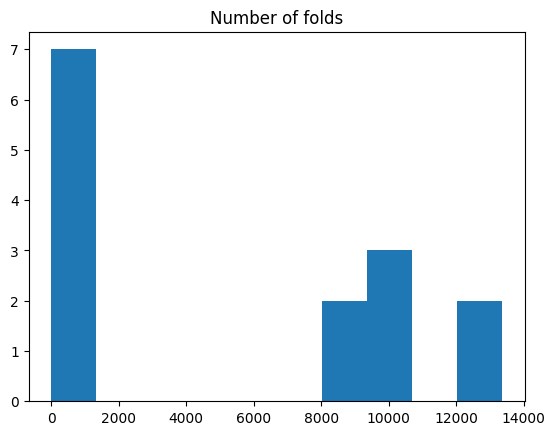

Mean fold count: 5377.714285714285 folds, out of 857375 locations.


In [54]:
num_batches_for_histogram = 5 #200  # sample this many batches

fold_counts = []  # Each element is the number of folds that occur in the registration of some image pair
negative_det_values = []  # Each element is the jacobian determinant at some fold for some image pair
reg_net.eval()
with torch.no_grad():
    for batch in batch_generator_valid_reg(num_batches_for_histogram):
        img12 = batch["img12"].to(device)
        displacement_fields = reg_net(img12)
        for displacement_field in displacement_fields:
            det = jacobian_determinant(displacement_field.cpu())
            num_folds = (det <= 0).sum()
            fold_counts.append(num_folds)
            if len(negative_det_values) < 1e6:  # Limit how many of these values we store
                negative_det_values += det[det <= 0].tolist()

del img12, displacement_fields
torch.cuda.empty_cache()

plt.hist(fold_counts)
plt.title("Number of folds")
plt.savefig("histogram_num_folds.png")
plt.show()
print(f"Mean fold count: {np.mean(fold_counts)} folds, out of {det.size} locations.")

### Negative Jacobian values

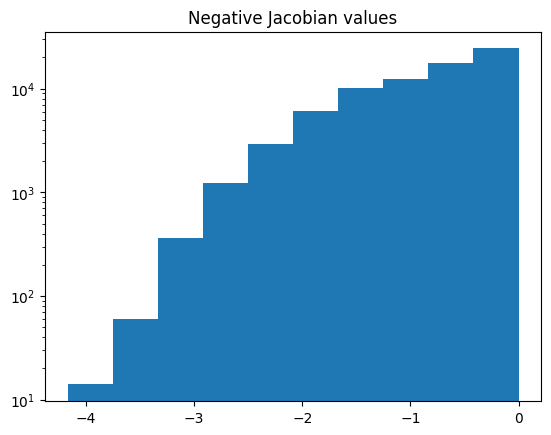

In [55]:
plt.hist(negative_det_values)

# View counts logarithmically to see details for the worse jacobians, where counts are usually smaller
plt.yscale("log")

plt.title("Negative Jacobian values")
plt.savefig("histogram_neg_jac.png")
plt.show()